requirements.txt

```
numpy
tensorflow_hub
tensorflow
pandas
tensorflow-text
transformers
matplotlib
```



In [ ]:
!pip install -r https://raw.githubusercontent.com/LizaAmatya/FakeNewsDetection/main/requirements.txt

In [2]:
import os
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification, DistilBertTokenizer, TFDistilBertForSequenceClassification
import numpy as np

In [3]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.run_functions_eagerly(False)
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)
# mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1","/gpu:2", "/gpu:3"])

Running on TPU  ['10.117.180.154:8470']


In [4]:
# BASE_DIR = os.path.dirname(os.path.abspath(__file__))
BASE_DIR = "/content/sample_data"

In [5]:
# Enable autotuning
# tf.config.threading.set_intra_op_parallelism_threads(1)
# tf.config.threading.set_inter_op_parallelism_threads(1)
# tf.config.threading.set_intra_op_parallelism_threads(1)
# tf.config.threading.set_inter_op_parallelism_threads(1)

In [6]:
train_path = os.path.join(BASE_DIR, 'dataset/train.tsv')
test_path = os.path.join(BASE_DIR, 'dataset/test.tsv')
validation_path = os.path.join(BASE_DIR, 'dataset/validation.tsv')

In [7]:
column_labels = ['row', 'json_ids', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state', 'affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'lies_counts', 'context', 'justification']

In [8]:
# Data Frames
train = pd.read_csv(train_path, sep="\t", header=None, names=column_labels)
test = pd.read_csv(test_path, sep="\t", header=None, names=column_labels)
valid = pd.read_csv(validation_path, sep="\t", header=None, names=column_labels)

In [9]:
# Fill nan (empty boxes) with 0
train = train.fillna('None')
test = test.fillna('None')
val = valid.fillna('None')

Mapping to binary classes

In [10]:
labels = train['label']
label_mapping = {label: idx for idx, label in enumerate(labels.unique())}
print('label mapping', label_mapping)

label mapping {'false': 0, 'half-true': 1, 'mostly-true': 2, 'true': 3, 'barely-true': 4, 'pants-fire': 5}


In [11]:
# Converting into 2 labels
train['label_encoded'] = np.where(np.isin(labels, ['mostly-true', 'true']), 1, 0)   # Mapping True as 1 and lies as 0
val['label_encoded'] = np.where(np.isin(val['label'], ['mostly-true', 'true']), 1, 0)

In [12]:
num_of_classes=2

In [13]:
# model_name = 'experts_wiki_books'
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [14]:
# Tokenize the statement and metadata
train_encoded_statement_data = tokenizer(
    train['statement'].to_list(),
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='tf'
)
train['metadata'] = train['subject'].astype(str) + ' ' + train['speaker'].astype(str) + ' ' + train['job_title'].astype(str) + ' ' + train['state'].astype(str) + ' ' + train['affiliation'].astype(str) + ' ' + train['context'].astype(str)

train_encoded_metadata = tokenizer(
    train['metadata'].to_list(),
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='tf'
)

In [15]:
val_encoded_statement_data = tokenizer(
    val['statement'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='tf'
)
val['metadata'] = val['subject'].astype(str) + ' ' + val['speaker'].astype(str) + ' ' + val['job_title'].astype(str) + ' ' + val['state'].astype(str) + ' ' + val['affiliation'].astype(str) + ' ' + val['context'].astype(str)

val_encoded_metadata = tokenizer(
    val['metadata'].to_list(),
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='tf'
)

In [16]:
# Create TensorFlow dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_encoded_statement_data['input_ids'],
        'attention_mask': train_encoded_statement_data['attention_mask'],
        'input_ids_metadata': train_encoded_metadata['input_ids'],
        'attention_mask_metadata': train_encoded_metadata['attention_mask']
    },
    train['label_encoded'] ))

In [17]:
val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': val_encoded_statement_data['input_ids'],
        'attention_mask': val_encoded_statement_data['attention_mask'],
        'input_ids_metadata': val_encoded_metadata['input_ids'],
        'attention_mask_metadata': val_encoded_metadata['attention_mask']

    },
    val['label_encoded'] ))

In [18]:
num_epochs = 10
batch_size = 32

In [19]:
# Creating model with BERT with 2 layers of input
from tensorflow.keras.layers import Input

max_length = 128
def create_bert_model():
    model_name = 'bert-base-uncased'
    model = TFBertForSequenceClassification.from_pretrained(model_name)

    # Define input layers
    input_ids_statement = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_mask_statement = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
    input_ids_metadata = Input(shape=(max_length,), dtype=tf.int32, name='input_ids_metadata')
    attention_mask_metadata = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_metadata')

    bert_output_statement = model([input_ids_statement, attention_mask_statement])
    bert_output_metadata = model([input_ids_metadata, attention_mask_metadata])

    # Extract logits for the positive class from each branch
    positive_class_statement_logits = bert_output_statement.logits[:, 1]
    positive_class_metadata_logits = bert_output_metadata.logits[:, 1]

    positive_class_statement_logits = tf.expand_dims(positive_class_statement_logits, axis=-1)
    positive_class_metadata_logits = tf.expand_dims(positive_class_metadata_logits, axis=-1)

    # Add dense layers for classification on each branch
    dense_layer_statement = tf.keras.layers.Dense(256, activation='relu')(positive_class_statement_logits)
    dense_layer_metadata = tf.keras.layers.Dense(256, activation='relu')(bert_output_metadata.logits)

    # Merge the outputs using Concatenate or other merging strategies
    merged_output = tf.keras.layers.Concatenate(axis=-1)([dense_layer_statement, dense_layer_metadata])

    # Add additional dense layers for classification
    final_dense_layer = tf.keras.layers.Dense(128, activation='relu')(merged_output)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(final_dense_layer)

    custom_model = tf.keras.Model(inputs=[input_ids_statement, attention_mask_statement, input_ids_metadata, attention_mask_metadata],
                                  outputs=output)
    custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['accuracy'])

    return custom_model

In [20]:
# Create a new model with the BERT base and the custom output layer having only single layer of input

def create_model():
  model = TFBertForSequenceClassification.from_pretrained(model_name)
  input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids')
  attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask')

  # Adding a dense layer for the output
  bert_output = model([input_ids, attention_mask])
  cls_token = bert_output.logits
  positive_class_logits = cls_token[:, 1]  # Extract logits for the positive class
  positive_class_logits = tf.expand_dims(positive_class_logits, axis=-1)
  dense_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='dense_output')
  output = dense_layer(positive_class_logits)

  output = tf.keras.layers.Dense(1, activation='sigmoid')(output)
  custom_model = tf.keras.Model(inputs=model.input, outputs=output)
  custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['accuracy'])

  return custom_model

In [21]:
# strategy = tf.distribute.MirroredStrategy()
with tpu_strategy.scope():
    custom_model = create_bert_model()

custom_model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_for_sequence_class  TFSequenceClassifierOutput   1094837   ['input_ids[0][0]',           
 ification (TFBertForSequen  (loss=None, logits=(None,    78         'attention_mask[0][0]',      
 ceClassification)           2),                                     'input_ids_metadata[0][0]

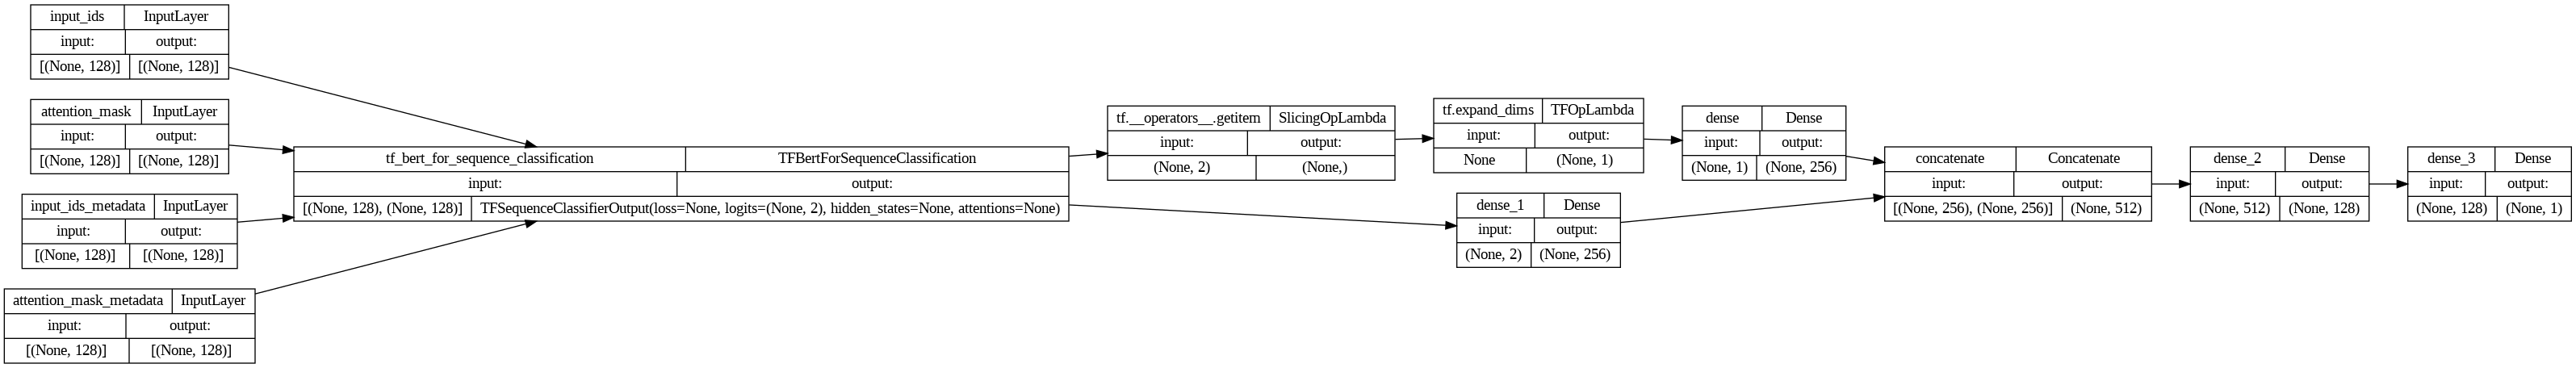

In [22]:
from tensorflow.keras.utils import plot_model

plot_model(custom_model, to_file='binary_custom_model.png', show_shapes=True, show_layer_names=True)

# If you want to save separate images for train, validation, and test datasets
plot_model(custom_model, to_file='train_model_binary.png', show_shapes=True, show_layer_names=True, rankdir='LR')
# plot_model(custom_model, to_file='validation_model.png', show_shapes=True, show_layer_names=True, rankdir='LR')
# plot_model(custom_model, to_file='test_model.png', show_shapes=True, show_layer_names=True, rankdir='LR')

In [23]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(BASE_DIR, 'model_checkpoint'),  # Specify the path to save the checkpoint
    save_best_only=True,  # Save only the best model based on the validation loss
    monitor='val_loss',  # Monitor the validation loss
    mode='min',  # Mode can be 'min' or 'max' depending on the monitored metric
    verbose=1  # Show progress while saving
)

In [24]:
from tqdm import tqdm
from tensorflow.keras.callbacks import Callback

train_steps_per_epoch = len(train_dataset)
tqdm_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_begin=lambda epoch, logs: tqdm(total=train_steps_per_epoch, position=0, desc="Epoch", unit="batch"),
    on_epoch_end=lambda epoch, logs: tqdm.write(f'Epoch {epoch + 1}/{num_epochs}, Loss: {logs["loss"]}, Accuracy: {logs["sparse_categorical_accuracy"]}, Val Loss: {logs["val_loss"]}, Val Accuracy: {logs["val_sparse_categorical_accuracy"]}'),
    on_batch_end=lambda batch, logs: tqdm.update(1)
)

class ProgressBarCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs += 1
        self.pbar.update(1)
        self.pbar.set_postfix(logs, refresh=True)

    def on_train_begin(self, logs=None):
        self.epochs = 0
        self.pbar = tqdm(total=self.params['epochs'], unit='epoch', position=0)

    def on_train_end(self, logs=None):
        self.pbar.close()

In [25]:
print('Start training')
progress_bar_callback = ProgressBarCallback()
history = custom_model.fit(
    train_dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE),
    epochs=num_epochs,
    validation_data=val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE),
    verbose=1,
    callbacks=[progress_bar_callback]
)

Start training


  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1/10
  6/320 [..............................] - ETA: 33s - loss: 0.6834 - accuracy: 0.6354

320/320 [==============================] - ETA: 0s - loss: 0.6501 - accuracy: 0.6444

 10%|█         | 1/10 [03:05<27:48, 185.40s/epoch, loss=0.65, accuracy=0.644, val_loss=0.635, val_accuracy=0.673]

320/320 [==============================] - 183s 186ms/step - loss: 0.6501 - accuracy: 0.6444 - val_loss: 0.6352 - val_accuracy: 0.6729
Epoch 2/10
320/320 [==============================] - ETA: 0s - loss: 0.6519 - accuracy: 0.6447

 20%|██        | 2/10 [03:42<13:03, 97.93s/epoch, loss=0.652, accuracy=0.645, val_loss=0.633, val_accuracy=0.673]

320/320 [==============================] - 36s 112ms/step - loss: 0.6519 - accuracy: 0.6447 - val_loss: 0.6329 - val_accuracy: 0.6729
Epoch 3/10
320/320 [==============================] - ETA: 0s - loss: 0.6519 - accuracy: 0.6447

 30%|███       | 3/10 [04:18<08:08, 69.81s/epoch, loss=0.652, accuracy=0.645, val_loss=0.635, val_accuracy=0.673]

320/320 [==============================] - 36s 112ms/step - loss: 0.6519 - accuracy: 0.6447 - val_loss: 0.6353 - val_accuracy: 0.6729
Epoch 4/10
320/320 [==============================] - ETA: 0s - loss: 0.6529 - accuracy: 0.6447

 40%|████      | 4/10 [04:55<05:40, 56.71s/epoch, loss=0.653, accuracy=0.645, val_loss=0.636, val_accuracy=0.673]

320/320 [==============================] - 36s 112ms/step - loss: 0.6529 - accuracy: 0.6447 - val_loss: 0.6359 - val_accuracy: 0.6729
Epoch 5/10
320/320 [==============================] - ETA: 0s - loss: 0.6513 - accuracy: 0.6447

 50%|█████     | 5/10 [05:31<04:07, 49.40s/epoch, loss=0.651, accuracy=0.645, val_loss=0.64, val_accuracy=0.673] 

320/320 [==============================] - 36s 111ms/step - loss: 0.6513 - accuracy: 0.6447 - val_loss: 0.6398 - val_accuracy: 0.6729
Epoch 6/10
320/320 [==============================] - ETA: 0s - loss: 0.6515 - accuracy: 0.6447

 60%|██████    | 6/10 [06:08<03:00, 45.05s/epoch, loss=0.651, accuracy=0.645, val_loss=0.632, val_accuracy=0.673]

320/320 [==============================] - 36s 112ms/step - loss: 0.6515 - accuracy: 0.6447 - val_loss: 0.6324 - val_accuracy: 0.6729
Epoch 7/10
320/320 [==============================] - ETA: 0s - loss: 0.6518 - accuracy: 0.6447

 70%|███████   | 7/10 [06:44<02:06, 42.27s/epoch, loss=0.652, accuracy=0.645, val_loss=0.635, val_accuracy=0.673]

320/320 [==============================] - 36s 112ms/step - loss: 0.6518 - accuracy: 0.6447 - val_loss: 0.6350 - val_accuracy: 0.6729
Epoch 8/10
320/320 [==============================] - ETA: 0s - loss: 0.6515 - accuracy: 0.6447

 80%|████████  | 8/10 [07:22<01:21, 40.93s/epoch, loss=0.651, accuracy=0.645, val_loss=0.636, val_accuracy=0.673]

320/320 [==============================] - 36s 113ms/step - loss: 0.6515 - accuracy: 0.6447 - val_loss: 0.6355 - val_accuracy: 0.6729
Epoch 9/10
320/320 [==============================] - ETA: 0s - loss: 0.6511 - accuracy: 0.6447

 90%|█████████ | 9/10 [08:01<00:40, 40.16s/epoch, loss=0.651, accuracy=0.645, val_loss=0.641, val_accuracy=0.673]

320/320 [==============================] - 38s 118ms/step - loss: 0.6511 - accuracy: 0.6447 - val_loss: 0.6410 - val_accuracy: 0.6729
Epoch 10/10
320/320 [==============================] - ETA: 0s - loss: 0.6519 - accuracy: 0.6447

100%|██████████| 10/10 [08:38<00:00, 39.17s/epoch, loss=0.652, accuracy=0.645, val_loss=0.633, val_accuracy=0.673]

320/320 [==============================] - 36s 113ms/step - loss: 0.6519 - accuracy: 0.6447 - val_loss: 0.6329 - val_accuracy: 0.6729


100%|██████████| 10/10 [08:38<00:00, 51.82s/epoch, loss=0.652, accuracy=0.645, val_loss=0.633, val_accuracy=0.673]


In [26]:
# Save the trained model if needed
# custom_model.save(os.path.join(BASE_DIR, 'trained_model'))

In [29]:
# from keras.utils import Progbar

# Tokenize and preprocess the test data
test_encoded_statement_data = tokenizer(
    test['statement'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='tf'
)
test['label_encoded'] = train['label'].map(label_mapping)
test['metadata'] = test['subject'].astype(str) + ' ' + test['speaker'].astype(str) + ' ' + test['job_title'].astype(str) + ' ' + test['state'].astype(str) + ' ' + test['affiliation'].astype(str) + ' ' + test['context'].astype(str)

test_encoded_metadata = tokenizer(
    test['metadata'].to_list(),
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='tf'
)

# Create TensorFlow dataset for testing
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_encoded_statement_data['input_ids'],
        'attention_mask': test_encoded_statement_data['attention_mask'],
        'input_ids_metadata': test_encoded_metadata['input_ids'],
        'attention_mask_metadata': test_encoded_metadata['attention_mask']
    },
    test['label_encoded']
))

test_steps = len(test_dataset)
# progbar = Progbar(test_steps)

# Evaluate the model on the test dataset
with tpu_strategy.scope():
  results = custom_model.evaluate(test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE))

# Display the results and update the progress bar
for metric_name, result in zip(custom_model.metrics_names, results):
    print(f'{metric_name}: {result}')

    # Update progress bar
    # progbar.update(1)
# Print the evaluation results (including accuracy)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

40/40 [==============================] - 3s 39ms/step - loss: 1.7494 - accuracy: 0.2058
loss: 1.7493821382522583
accuracy: 0.2058359682559967
Test Loss: 1.7493821382522583
Test Accuracy: 0.2058359682559967


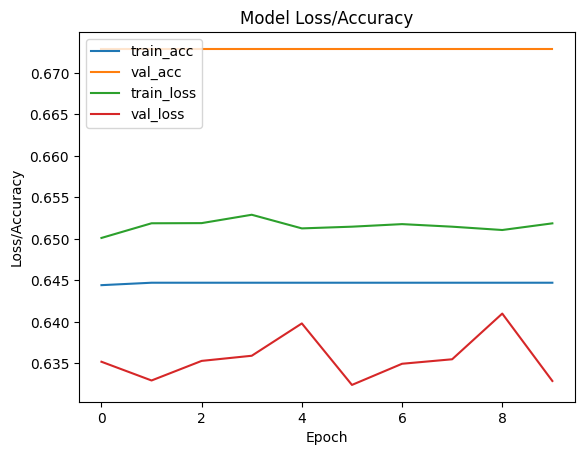

In [31]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss/Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'], loc='upper left')
plt.show()